### Nome: Fabio Grassiotto
### RA: 890441
### Disciplina: IA369Y, 2º S 2017

### T3 - Análise e Síntese de Emoções em Conteúdo Multimídia
### Atividade 6 - Tutorial: Emotion Recognition using Facial Landmarks, Python, DLib and OpenCV


As atividades deste jupyter notebook são derivadas do tutorial de van Gent, P. (2016). Emotion Recognition Using Facial Landmarks, Python, DLib and OpenCV, disponível no link http://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-landmarks/.

#### 1. Instalação da biblioteca DLib, utilizada para extração de marcos faciais.

- Seguindo o tutorial, realizei o download e instalação da CMake e Boost-Python (biblioteca C++).
- No Windows 10 apenas foi possível compilar a biblioteca Boost mesmo após instalar o Visual Studio 2015 para ter acesso a um compilador C/C++ e aos headers da SDK do Windows.
- Uma vez instalado o compilador, foi possível compilar a biblioteca, mas ocorreram problemas de link com a DLib.
- Encontrei no site da Boost binários pré-compilados. Com os mesmos, ainda não foi possível linkar a DLib.
- Procurando pela internet, existe um pacote pronto para o ambiente Anaconda em Windows, o que foi utilizado para instalar a DLib.

<code>conda install -c conda-forge dlib=19.4

Fetching package metadata .............
Solving package specifications: .

The following NEW packages will be INSTALLED:

    boost:     1.64.0-py36_vc14_4 conda-forge [vc14]
    boost-cpp: 1.64.0-vc14_1      conda-forge [vc14]
    dlib:      19.4-np113py36_201 conda-forge
    mkl:       2017.0.3-0
    numpy:     1.13.1-py36_0
    vc:        14-0               conda-forge

Proceed ([y]/n)? y</code>

In [15]:
import dlib
print(dlib.__version__)

19.4.0


Após executar o import, a dlib agora está disponível no Python.

#### 2. Teste do detector de landmarks

Ao executar o código do tutorial, o interpretador do Python acusa que a biblioteca cv2 (Open CV 3) não está disponível.
Para Python 3.6, é necessário fazer o download do binário no site https://www.lfd.uci.edu/~gohlke/pythonlibs/#opencv e instalar manualmente:

pip install opencv_python-3.3.1-cp36-cp36m-win_amd64.whl
Processing d:\development\libs\opencv_python-3.3.1-cp36-cp36m-win_amd64.whl
Installing collected packages: opencv-python
Successfully installed opencv-python-3.3.1

In [ ]:
import cv2
print(cv2.__version__)

O código abaixo foi então executado para capturar e detectar o rosto usando a webcam do computador:

In [ ]:
#Import required modules
import cv2
import dlib

#Set up some required objects
video_capture = cv2.VideoCapture(0) #Webcam object
detector = dlib.get_frontal_face_detector() #Face detector
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Landmark identifier. Set the filename to whatever you named the downloaded file

while True:
    ret, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(gray)

    detections = detector(clahe_image, 1) #Detect the faces in the image

    for k,d in enumerate(detections): #For each detected face
        
        shape = predictor(clahe_image, d) #Get coordinates
        for i in range(1,68): #There are 68 landmark points on each face
            cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0,0,255), thickness=2) #For each point, draw a red circle with thickness2 on the original frame

    cv2.imshow("image", frame) #Display the frame

    if cv2.waitKey(1) & 0xFF == ord('q'): #Exit program when the user presses 'q'
        break

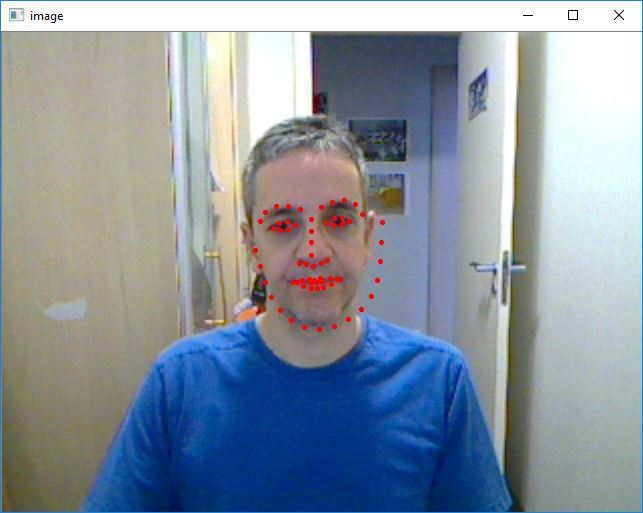

In [24]:
from IPython.display import Image, display
display(Image(filename='face_detect.jpg', embed=True))

#### 3. Extração de features de rostos

O código acima foi então modificado para a extração das coordenadas dos marcos faciais (feature) através da função get_landmarks().

In [23]:
import cv2
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
            
        for x, y in zip(xlist, ylist): #Store all landmarks in one list in the format x1,y1,x2,y2,etc.
            landmarks.append(x)
            landmarks.append(y)
    if len(detections) > 0:
        return landmarks
    else: #If no faces are detected, return error message to other function to handle
        landmarks = "error"
        return landmarks

A extração dos marcos faciais como feature pode no entanto ser um problema devido à movimentação do rosto. No tutorial, o autor inicialmente propõe normalizar as coordenadas dos marcos:

<code>xnorm = [(i-min(xlist))/(max(xlist)-min(xlist)) for i in xlist]
ynorm = [(i-min(ylist))/(max(ylist)-min(ylist)) for i in ylist]</code>

Essa abordagem provoca perda de informação quando comparamos duas fotos muito similares.
Uma alternativa seria calcular a posição dos pontos em relação a um centro de gravidade facial conforme ilustrado abaixo no tutorial.

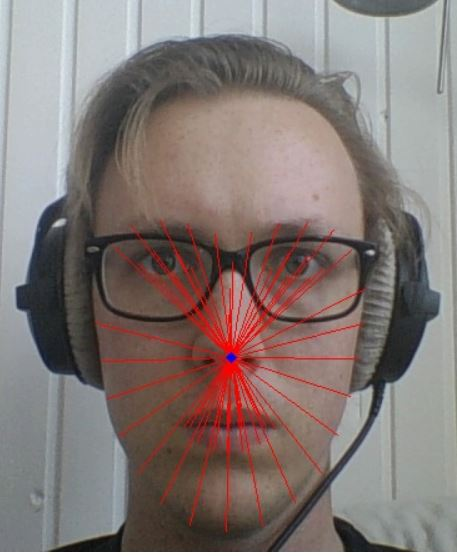

In [25]:
from IPython.display import Image, display
display(Image(filename='centerofgravity.jpg', embed=True))

O tutorial decorre então sobre as razões de não se usar a ponta do nariz como centro dos pontos:
- Os diferentes tipos de nariz introduziria variância.
- A posição da cabeça (por ex. inclinada) pode confundir o classificador.

Implementando a idéia do centro gravidade em Python:

In [26]:
def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
            
        xmean = np.mean(xlist) #Find both coordinates of centre of gravity
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist] #Calculate distance centre <-> other points in both axes
        ycentral = [(y-ymean) for y in ylist]
        
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))

        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1: 
        data['landmarks_vestorised'] = "error"

#### 4. Classificação de emoções do dataset Cohn-Kanade

Para a etapa final do tutorial, que fará a classificação de emoções de um dataset usando marcos faciais, será necessário instalar as bibliotecas scikit-learn e scipy.

##### Preparação do dataset
- Para execução da classificação, será utilizado o dataset Cohn-Kanade (Kanade, T., Cohn, J. F., & Tian, Y. (2000)).
- Foi realizado o download do dataset CK+ a partir do link http://www.consortium.ri.cmu.edu/ckagree/.
- O dataset será preparado de acordo com um tutorial anterior do mesmo autor disponível no link http://www.paulvangent.com/2016/04/01/emotion-recognition-with-python-opencv-and-a-face-dataset/.

Inicialmente, percebe-se que o dataset CK+ consiste de uma sequência de imagens com progressão de neutro para a emoção rotulada em cada uma das pastas de imagem conforme abaixo. 

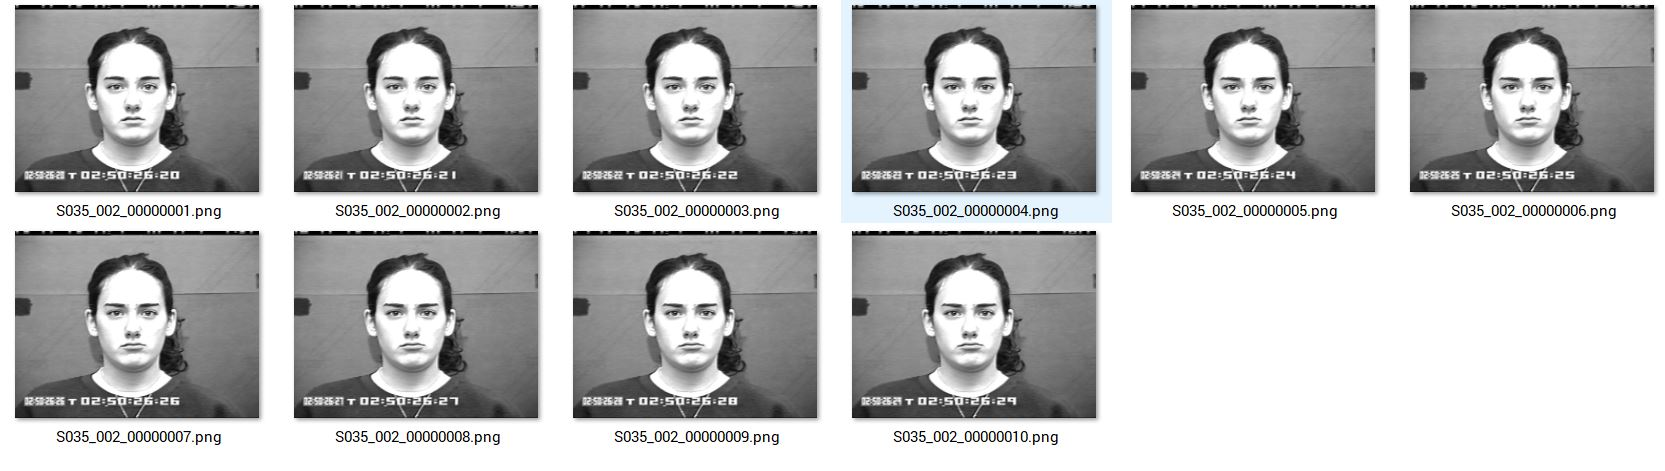

In [31]:
from IPython.display import Image, display
display(Image(filename='ck-images.jpg', embed=True))

Como precisamos apenas da imagem com a emoção final da progressão, será executado um script que seleciona as imagens de acordo com o rótulo emocional e coloca em uma nova estrutura de pastas agrupando por rótulo emocional. Essa operação é realizada no script prepare-set.py, com o resultado para os rótulos de felicidade logo abaixo.

In [28]:
import glob
from shutil import copyfile

emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Define emotion order
participants = glob.glob("source_emotion\\*") #Returns a list of all folders with participant numbers

for x in participants:
    part = "%s" %x[-4:] #store current participant number
    for sessions in glob.glob("%s\\*" %x): #Store list of sessions for current participant
        for files in glob.glob("%s\\*" %sessions):
            current_session = files[20:-30]
            file = open(files, 'r')
            
            emotion = int(float(file.readline())) #emotions are encoded as a float, readline as float, then convert to integer.
            
            sourcefile_emotion = glob.glob("source_images\\%s\\%s\\*" %(part, current_session))[-1] #get path for last image in sequence, which contains the emotion
            sourcefile_neutral = glob.glob("source_images\\%s\\%s\\*" %(part, current_session))[0] #do same for neutral image
            
            dest_neut = "sorted_set\\neutral\\%s" %sourcefile_neutral[25:] #Generate path to put neutral image
            dest_emot = "sorted_set\\%s\\%s" %(emotions[emotion], sourcefile_emotion[25:]) #Do same for emotion containing image
            
            copyfile(sourcefile_neutral, dest_neut) #Copy file
            copyfile(sourcefile_emotion, dest_emot) #Copy file

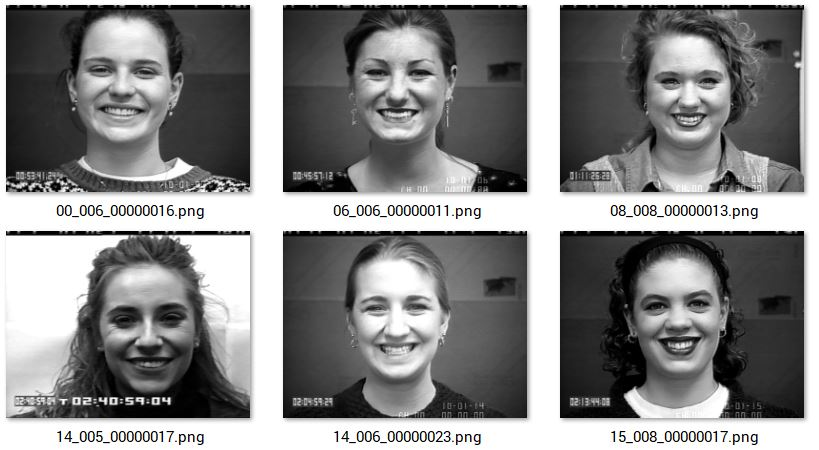

In [35]:
from IPython.display import Image, display
display(Image(filename='sorted-happy.jpg', embed=True))

Após preparada a estrutura de pastas, é necessário preparar as imagens para maximizar a performance do classificador. Para tanto, serão realizados dois passos:
- Manipulação as imagens para reter apenas as imagens dos rostos ("crop"), utilizando filtros HAAR da biblioteca OpenCV.
- Conversão das imagens para tons de cinza.
Essas duas operações são realizadas pelo script prepare-faces.py.

O resultado obtido pode ser visto logo abaixo.

In [ ]:
import cv2
import glob

faceDet = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
faceDet_two = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
faceDet_three = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")
faceDet_four = cv2.CascadeClassifier("haarcascade_frontalface_alt_tree.xml")

emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Define emotions

def detect_faces(emotion):
    files = glob.glob("sorted_set\\%s\\*" %emotion) #Get list of all images with emotion

    filenumber = 0
    for f in files:
        frame = cv2.imread(f) #Open image
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
        
        #Detect face using 4 different classifiers
        face = faceDet.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
        face_two = faceDet_two.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
        face_three = faceDet_three.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
        face_four = faceDet_four.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)

        #Go over detected faces, stop at first detected face, return empty if no face.
        if len(face) == 1:
            facefeatures = face
        elif len(face_two) == 1:
            facefeatures = face_two
        elif len(face_three) == 1:
            facefeatures = face_three
        elif len(face_four) == 1:
            facefeatures = face_four
        else:
            facefeatures = ""
        
        #Cut and save face
        for (x, y, w, h) in facefeatures: #get coordinates and size of rectangle containing face
            print("face found in file: %s" %f)
            gray = gray[y:y+h, x:x+w] #Cut the frame to size
            
            try:
                out = cv2.resize(gray, (350, 350)) #Resize face so all images have same size
                cv2.imwrite("dataset\\%s\\%s.jpg" %(emotion, filenumber), out) #Write image
            except:
               pass #If error, pass file
        filenumber += 1 #Increment image number

for emotion in emotions: 
    detect_faces(emotion) #Call functions

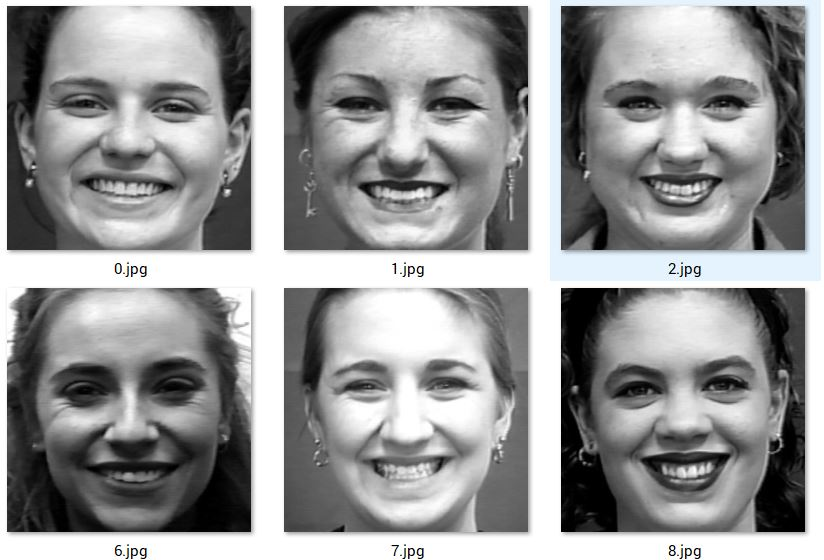

In [34]:
from IPython.display import Image, display
display(Image(filename='cropped-happy.jpg', embed=True))

##### Execução do Classificador
Aoós preparação do dataset na estrutura desejada, é realizada uma divisão do mesmo em um conjunto de treinamento, com 20% do set,
e um conjunto de classificação com 80% do set. Tal divisão é realizada de forma aleatória.

A classificação foi então executada pelo script classifier.py, executando 10 vezes a mesma operação para derivar uma média da
performance do classificador.

In [29]:
import cv2
import glob
import random
import math
import numpy as np
import dlib
import itertools
from sklearn.svm import SVC

emotions = ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"] #Emotion list
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Or set this to whatever you named the downloaded file
clf = SVC(kernel='linear', probability=True, tol=1e-3)#, verbose = True) #Set the classifier as a support vector machines with polynomial kernel

data = {} #Make dictionary for all values
#data['landmarks_vectorised'] = []

def get_files(emotion): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("dataset\\%s\\*" %emotion)
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #get first 80% of file list
    prediction = files[-int(len(files)*0.2):] #get last 20% of file list
    return training, prediction

def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
            
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist]
        ycentral = [(y-ymean) for y in ylist]

        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))

        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1: 
        data['landmarks_vestorised'] = "error"

def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for emotion in emotions:
        print((" working on %s" %emotion))
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            image = cv2.imread(item) #open image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                training_data.append(data['landmarks_vectorised']) #append image array to training data list
                training_labels.append(emotions.index(emotion))
    
        for item in prediction:
            image = cv2.imread(item)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                prediction_data.append(data['landmarks_vectorised'])
                prediction_labels.append(emotions.index(emotion))

    return training_data, training_labels, prediction_data, prediction_labels   

accur_lin = []
for i in range(0,10):
    print(("Making sets %s" %i)) #Make sets by random sampling 80/20%
    training_data, training_labels, prediction_data, prediction_labels = make_sets()

    npar_train = np.array(training_data) #Turn the training set into a numpy array for the classifier
    npar_trainlabs = np.array(training_labels)
    print(("training SVM linear %s" %i)) #train SVM
    clf.fit(npar_train, training_labels)

    print(("getting accuracies %s" %i)) #Use score() function to get accuracy
    npar_pred = np.array(prediction_data)
    pred_lin = clf.score(npar_pred, prediction_labels)
    print("linear: ", pred_lin)
    accur_lin.append(pred_lin) #Store accuracy in a list

print(("Mean value lin svm: %s" %np.mean(accur_lin))) #FGet mean accuracy of the 10 runs

Making sets 0
 working on anger
 working on contempt
 working on disgust
 working on fear
 working on happiness
 working on neutral
 working on sadness
 working on surprise
training SVM linear 0
getting accuracies 0
linear:  0.818181818182
Making sets 1
 working on anger
 working on contempt
 working on disgust
 working on fear
 working on happiness
 working on neutral
 working on sadness
 working on surprise
training SVM linear 1
getting accuracies 1
linear:  0.845454545455
Making sets 2
 working on anger
 working on contempt
 working on disgust
 working on fear
 working on happiness
 working on neutral
 working on sadness
 working on surprise
training SVM linear 2
getting accuracies 2
linear:  0.863636363636
Making sets 3
 working on anger
 working on contempt
 working on disgust
 working on fear
 working on happiness
 working on neutral
 working on sadness
 working on surprise
training SVM linear 3
getting accuracies 3
linear:  0.845454545455
Making sets 4
 working on anger
 working

#### 5. Resultados e Conclusões



Referências:
- van Gent, P. (2016). Emotion Recognition Using Facial Landmarks, Python, DLib and OpenCV. A tech blog about fun things with Python and embedded electronics. Retrieved from: http://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-landmarks/
- Kanade, T., Cohn, J. F., & Tian, Y. (2000). Comprehensive database for facial expression analysis. Proceedings of the Fourth IEEE International Conference on Automatic Face and Gesture Recognition (FG'00), Grenoble, France, 46-53.
- Lucey, P., Cohn, J. F., Kanade, T., Saragih, J., Ambadar, Z., & Matthews, I. (2010). The Extended Cohn-Kanade Dataset (CK+): A complete expression dataset for action unit and emotion-specified expression. Proceedings of the Third International Workshop on CVPR for Human Communicative Behavior Analysis (CVPR4HB 2010), San Francisco, USA, 94-101.